# Basketball Fan Retention - Model Explanation with SHAP

This notebook provides interpretability analysis for the churn prediction model using SHAP (SHapley Additive exPlanations).

## Contents
1. Load Trained Models
2. SHAP Explainer Setup
3. Global Feature Importance
4. Individual Prediction Explanations
5. Feature Interaction Analysis
6. Customer Segment Analysis
7. Export Explanation Artifacts

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
from pathlib import Path

# Add src to path
import sys
sys.path.append(str(Path.cwd().parent / "src"))
from config import get_data_paths, load_config

print("Libraries imported successfully!")
shap.initjs()  # Initialize SHAP for Jupyter

Libraries imported successfully!


## 1. Load Trained Models and Data

Load the best performing churn model and test data for explanation analysis.

In [2]:
# Load configuration and data paths
config = load_config()
data_paths = get_data_paths()

# Load model artifacts
with open(data_paths['processed_models'] / 'churn_model_artifacts.pkl', 'rb') as f:
    model_artifacts = pickle.load(f)

# Extract components
model = model_artifacts['best_model']
scaler = model_artifacts['scaler']
imputer = model_artifacts['imputer']
feature_names = model_artifacts['feature_names']

print(f"Loaded model: {model_artifacts['model_name']}")
print(f"Number of features: {len(feature_names)}")

Loaded model: XGBoost
Number of features: 41


In [3]:
# Debug: Check what data paths are available
print("Available data paths:")
for key, value in data_paths.items():
    print(f"  {key}: {value}")
    
print("\nChecking for test data files...")
from pathlib import Path
data_dir = Path.cwd().parent / "data"
if data_dir.exists():
    print(f"Data directory exists: {data_dir}")
    for subdir in data_dir.iterdir():
        if subdir.is_dir():
            print(f"  Subdirectory: {subdir}")
            for file in subdir.glob("*.csv"):
                print(f"    CSV file: {file}")
else:
    print(f"Data directory not found: {data_dir}")

Available data paths:
  raw_api: c:\Users\tifek\GitHub\basketball_fan_retention\data\raw\api
  raw_bbref: c:\Users\tifek\GitHub\basketball_fan_retention\data\raw\bbref
  raw_synth: c:\Users\tifek\GitHub\basketball_fan_retention\data\raw\synth
  processed_models: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\models
  processed_figures: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\figures
  processed_ltv: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\ltv
  processed_assignments: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\assignments

Checking for test data files...
Data directory exists: c:\Users\tifek\GitHub\basketball_fan_retention\data
  Subdirectory: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed
    CSV file: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\engineered_features.csv
    CSV file: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\enhanced_engineered_features.csv


In [4]:
# Debug: Check model artifacts
print("Model artifacts keys:")
for key in model_artifacts.keys():
    print(f"  {key}: {type(model_artifacts[key])}")

print(f"\nModel type: {type(model)}")
print(f"Feature names count: {len(feature_names)}")
print(f"First 10 features: {feature_names[:10]}")

# Check if imputer and scaler are fitted
from sklearn.utils.validation import check_is_fitted

try:
    check_is_fitted(imputer)
    print("Imputer is fitted")
except:
    print("Imputer is NOT fitted")

try:
    check_is_fitted(scaler)  
    print("Scaler is fitted")
except:
    print("Scaler is NOT fitted")

Model artifacts keys:
  best_model: <class 'xgboost.sklearn.XGBClassifier'>
  model_name: <class 'str'>
  scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
  imputer: <class 'sklearn.impute._base.SimpleImputer'>
  feature_names: <class 'list'>
  performance_metrics: <class 'dict'>

Model type: <class 'xgboost.sklearn.XGBClassifier'>
Feature names count: 41
First 10 features: ['minutes_watched', 'app_logins', 'tickets_purchased', 'merch_spend', 'support_tickets', 'promo_exposure', 'social_media_engagement', 'engagement_score', 'engagement_trend', 'usage_intensity']
Imputer is NOT fitted
Scaler is fitted


In [5]:
# Check scaler details
print(f"Scaler expects {scaler.n_features_in_} features")
print(f"We have {len(feature_names)} feature names")

# Check if there are feature names stored in the scaler
if hasattr(scaler, 'feature_names_in_'):
    print(f"Scaler feature names: {len(scaler.feature_names_in_)}")
    scaler_features = list(scaler.feature_names_in_)
    print(f"First 10 scaler features: {scaler_features[:10]}")
    
    # Find the difference
    model_features_set = set(scaler_features)
    provided_features_set = set(feature_names)
    
    print(f"\nFeatures in model but not in provided list:")
    print(model_features_set - provided_features_set)
    
    print(f"\nFeatures in provided list but not in model:")
    print(provided_features_set - model_features_set)
else:
    print("No feature names in scaler")

Scaler expects 33 features
We have 41 feature names
Scaler feature names: 33
First 10 scaler features: ['minutes_watched', 'app_logins', 'tickets_purchased', 'merch_spend', 'support_tickets', 'promo_exposure', 'social_media_engagement', 'engagement_score', 'engagement_trend', 'usage_intensity']

Features in model but not in provided list:
set()

Features in provided list but not in model:
{'segment_super_fan', 'plan_tier_premium', 'segment_casual', 'plan_tier_basic', 'segment_regular', 'plan_tier_vip', 'segment_avid', 'plan_tier_family'}


## 2. SHAP Explainer Setup

Initialize SHAP explainers for the trained model.

In [ ]:
# Load test data from enhanced synthetic dataset
processed_dir = Path.cwd().parent / "data" / "processed"
test_data = pd.read_csv(processed_dir / 'final_test_features.csv')
print(f"Loaded test data: {test_data.shape}")

# Use the actual features that the scaler was trained on
actual_feature_names = list(scaler.feature_names_in_)
print(f"Using {len(actual_feature_names)} features that model was trained on")

# Get the same features used in training
X_test = test_data[actual_feature_names]
print(f"Selected features: {X_test.shape}")

# Check for missing values
missing_values = X_test.isnull().sum()
print(f"Missing values per feature:")
print(missing_values[missing_values > 0])

# Handle preprocessing based on whether we have missing values
if missing_values.sum() > 0:
    print("Missing values found - fitting imputer on test data")
    # Fit imputer on the test data if it's not fitted
    X_test_imputed = imputer.fit_transform(X_test)
else:
    print("No missing values found - skipping imputation")
    X_test_imputed = X_test.values

# Scale the data
X_test_scaled = scaler.transform(X_test_imputed)
print(f"Data preprocessed successfully: {X_test_scaled.shape}")

# Initialize SHAP TreeExplainer for XGBoost model
explainer = shap.TreeExplainer(model)
print("SHAP TreeExplainer initialized")

# Calculate SHAP values for a subset of test data (for efficiency)
# Use first 1000 samples for SHAP analysis
n_samples = min(1000, len(X_test_scaled))
X_shap = X_test_scaled[:n_samples]

print(f"Calculating SHAP values for {n_samples} samples...")
shap_values = explainer.shap_values(X_shap)
print(f"SHAP values calculated: {shap_values.shape}")

# Store preprocessed data for later analysis
X_test_preprocessed = X_test_scaled
# Update feature names to match the actual model features
feature_names = actual_feature_names
print("SHAP explainer setup completed successfully!")

Loaded test data: (15614, 44)
Using 33 features that model was trained on
Selected features: (15614, 33)
Missing values per feature:
Series([], dtype: int64)
No missing values found - skipping imputation
Data preprocessed successfully: (15614, 33)


c:\Users\tifek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


SHAP TreeExplainer initialized
Calculating SHAP values for 1000 samples...
SHAP values calculated: (1000, 33)
SHAP explainer setup completed successfully!


## 3. Global Feature Importance

Generate SHAP summary plots and global feature importance analysis.

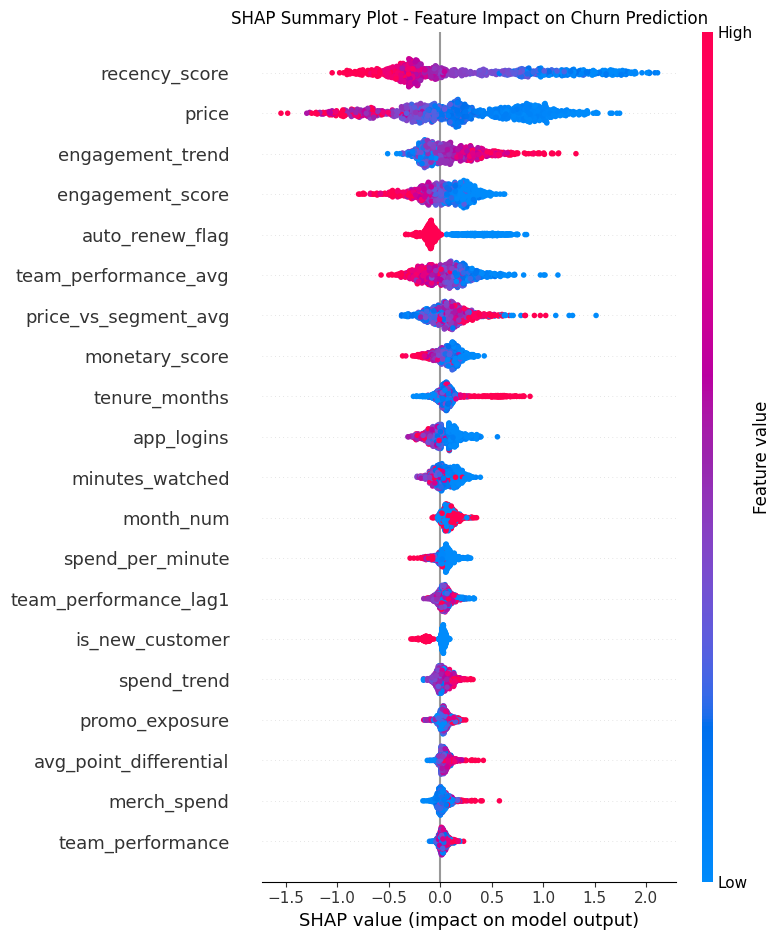

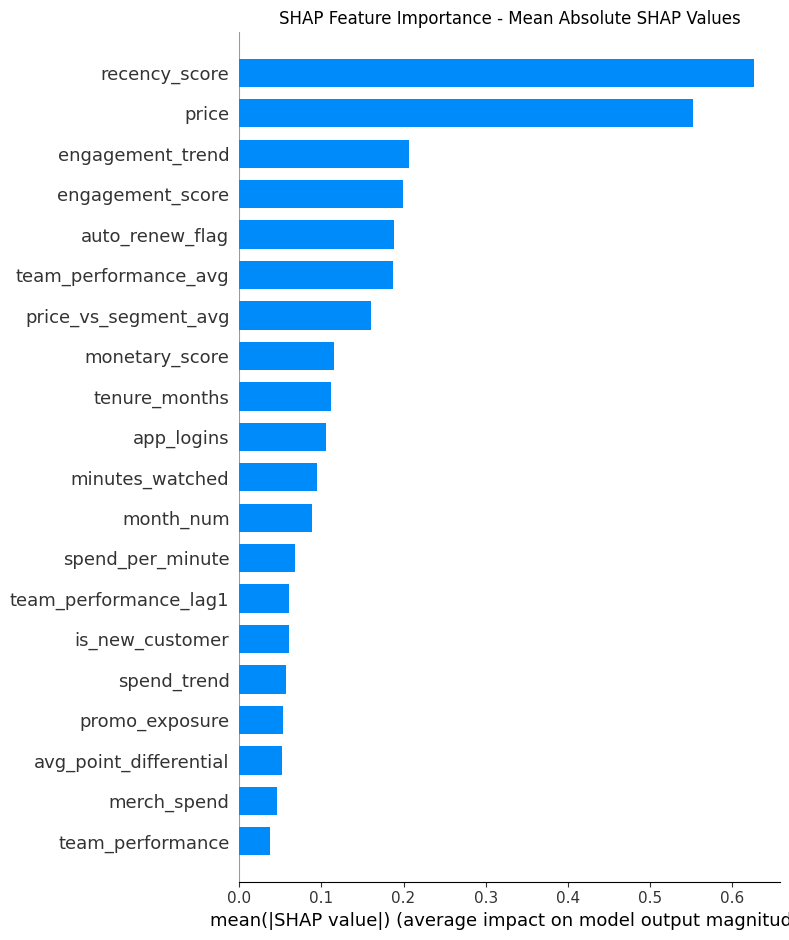

Top 20 Most Important Features (by SHAP):
                   feature  importance
14           recency_score    0.626989
10                   price    0.552967
8         engagement_trend    0.207107
7         engagement_score    0.198961
22         auto_renew_flag    0.188344
27    team_performance_avg    0.186846
24    price_vs_segment_avg    0.159960
11          monetary_score    0.115719
18           tenure_months    0.111750
1               app_logins    0.105759
0          minutes_watched    0.094548
30               month_num    0.088936
13        spend_per_minute    0.068131
26   team_performance_lag1    0.061131
19         is_new_customer    0.060760
12             spend_trend    0.056967
5           promo_exposure    0.053470
29  avg_point_differential    0.051489
3              merch_spend    0.045864
25        team_performance    0.037779


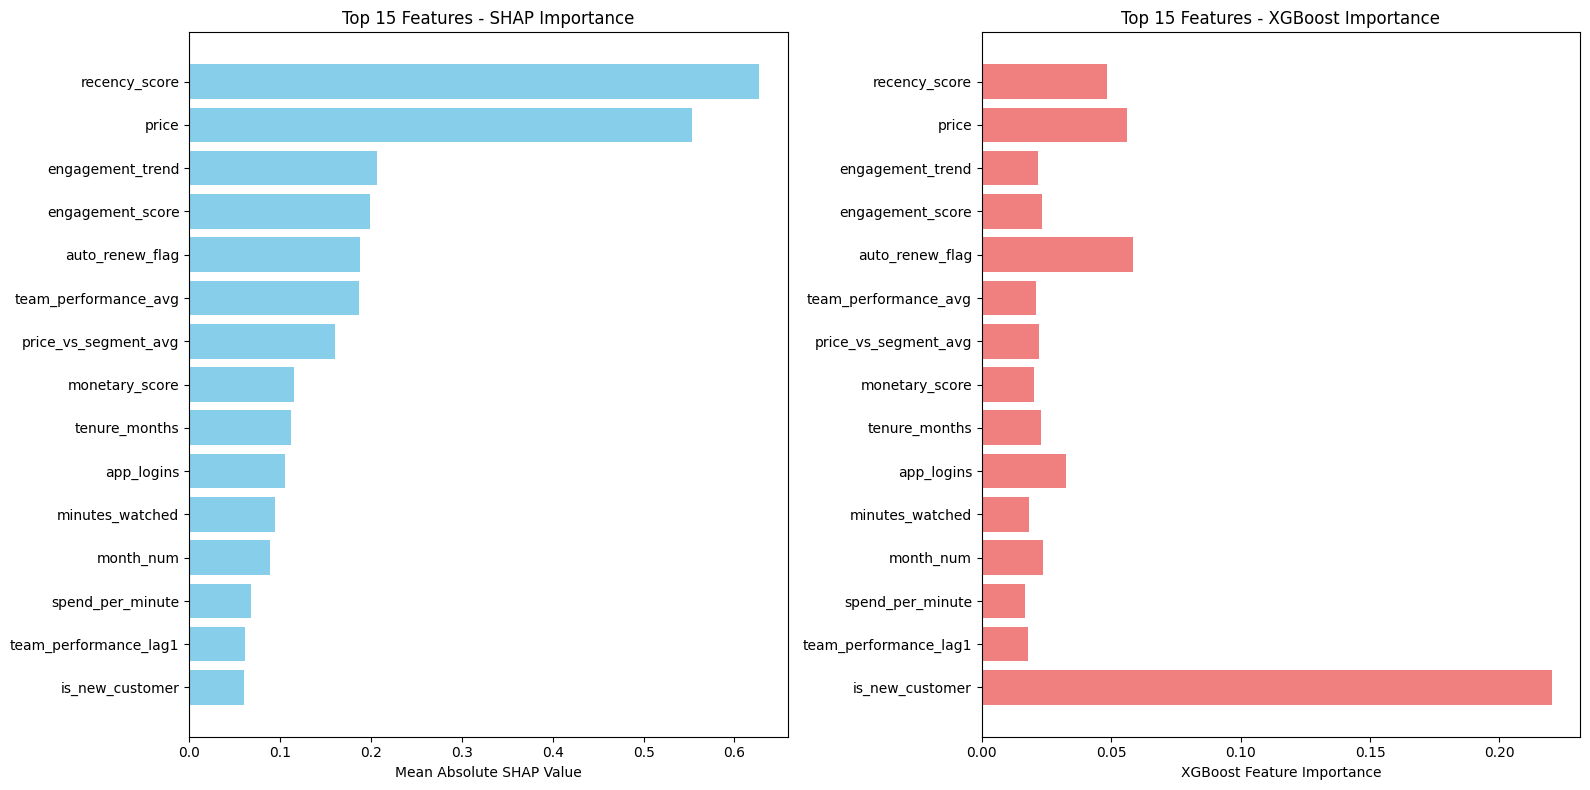

Global feature importance analysis completed!
Plots saved to: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\figures


In [7]:
# Create figures directory if it doesn't exist
figures_dir = data_paths['processed_figures']
figures_dir.mkdir(exist_ok=True)

# 1. SHAP Summary Plot (Beeswarm)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Churn Prediction')
plt.tight_layout()
plt.savefig(figures_dir / 'shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. SHAP Bar Plot (Mean Absolute SHAP Values)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, feature_names=feature_names, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Mean Absolute SHAP Values')
plt.tight_layout()
plt.savefig(figures_dir / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Feature Importance Ranking
# Calculate mean absolute SHAP values for ranking
mean_abs_shap = np.abs(shap_values).mean(0)
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features (by SHAP):")
print(feature_importance_df.head(20))

# 4. Compare with XGBoost native feature importance
xgb_importance = model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'feature': feature_names,
    'xgb_importance': xgb_importance
}).sort_values('xgb_importance', ascending=False)

# Merge SHAP and XGBoost importance
comparison_df = feature_importance_df.merge(
    xgb_importance_df, on='feature', suffixes=('_shap', '_xgb')
)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 features for readability
top_features = comparison_df.head(15)

# SHAP importance
ax1.barh(range(len(top_features)), top_features['importance'], color='skyblue')
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'])
ax1.set_xlabel('Mean Absolute SHAP Value')
ax1.set_title('Top 15 Features - SHAP Importance')
ax1.invert_yaxis()

# XGBoost importance
ax2.barh(range(len(top_features)), top_features['xgb_importance'], color='lightcoral')
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features['feature'])
ax2.set_xlabel('XGBoost Feature Importance')
ax2.set_title('Top 15 Features - XGBoost Importance')
ax2.invert_yaxis()

plt.tight_layout()
plt.savefig(figures_dir / 'feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Global feature importance analysis completed!")
print(f"Plots saved to: {figures_dir}")

## 4. Individual Prediction Explanations

Analyze SHAP explanations for individual customer predictions.

Representative Customer Analysis:

High Risk Customers:
  Customer 705: 0.984 churn probability
  Customer 646: 0.986 churn probability
  Customer 130: 0.988 churn probability
  Customer 389: 0.989 churn probability
  Customer 202: 0.989 churn probability

Low Risk Customers:
  Customer 442: 0.070 churn probability
  Customer 927: 0.071 churn probability
  Customer 763: 0.075 churn probability
  Customer 520: 0.079 churn probability
  Customer 276: 0.094 churn probability

Medium Risk Customers:
  Customer 210: 0.500 churn probability
  Customer 703: 0.501 churn probability
  Customer 950: 0.499 churn probability
  Customer 154: 0.504 churn probability
  Customer 285: 0.504 churn probability

Generating SHAP explanations for individual customers...


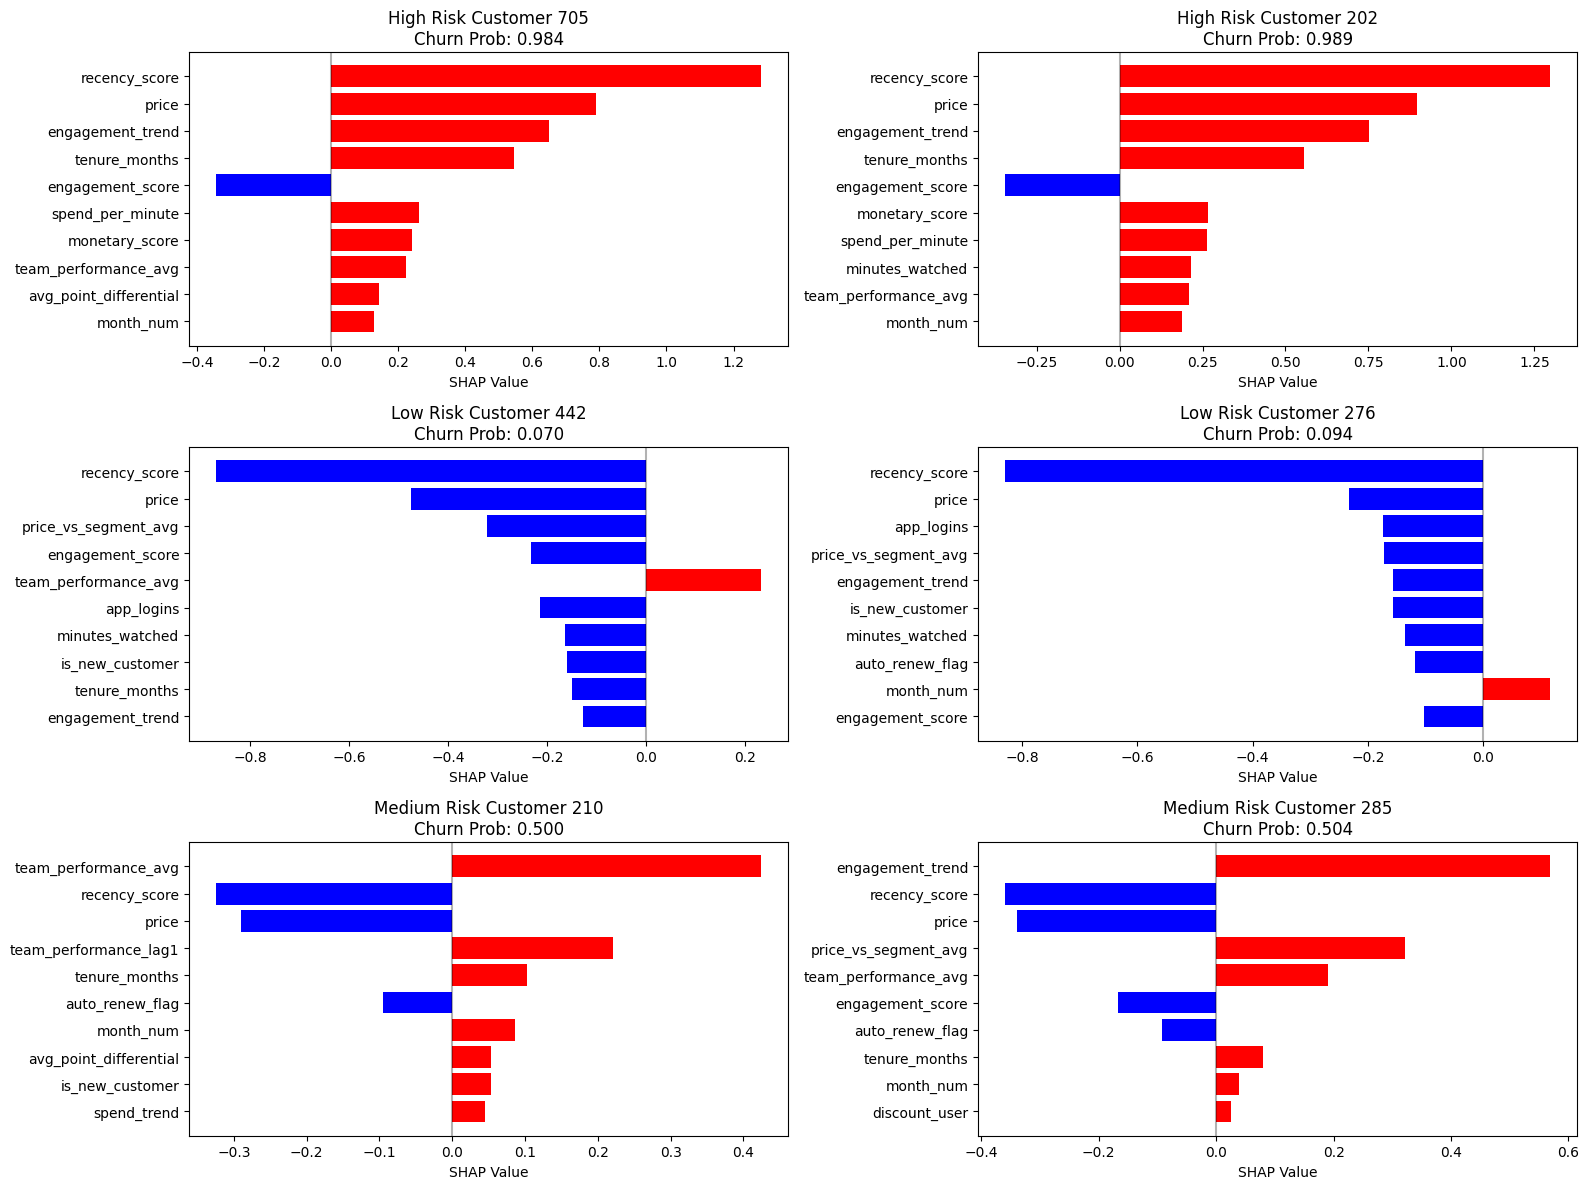

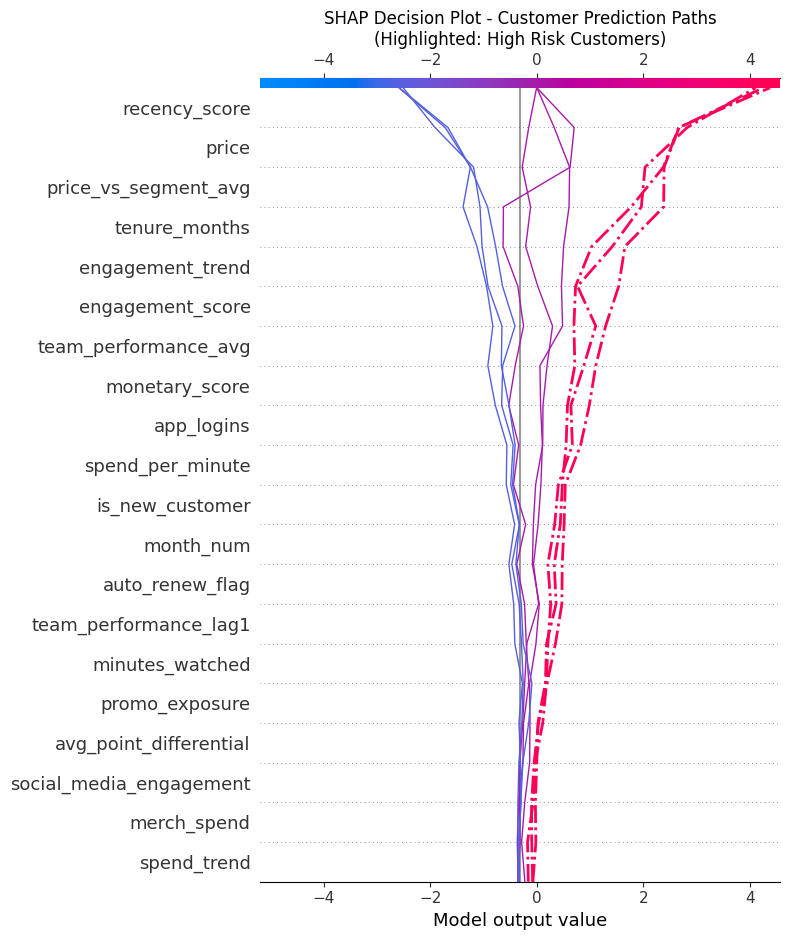


Detailed explanation for highest risk customer (index 202):
Churn probability: 0.989

Top 10 contributing features:
                 feature  shap_value
14         recency_score    1.296756
10                 price    0.894792
8       engagement_trend    0.752533
18         tenure_months    0.555434
7       engagement_score   -0.344478
11        monetary_score    0.267490
13      spend_per_minute    0.262837
0        minutes_watched    0.214530
27  team_performance_avg    0.208078
30             month_num    0.187151


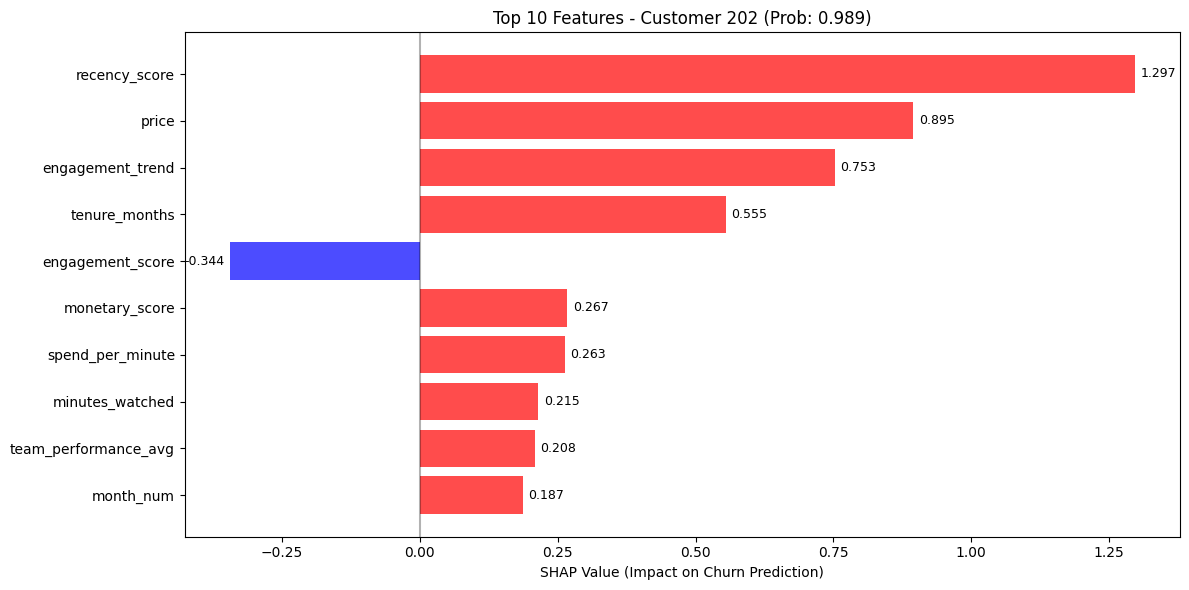

Individual prediction explanations completed!
Visualizations saved to: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\figures


In [8]:
# Get predictions for the SHAP subset
y_pred_proba = model.predict_proba(X_shap)[:, 1]

# Select representative customers
high_risk_idx = np.argsort(y_pred_proba)[-5:]  # Top 5 highest risk
low_risk_idx = np.argsort(y_pred_proba)[:5]    # Top 5 lowest risk
medium_risk_idx = np.argsort(np.abs(y_pred_proba - 0.5))[:5]  # 5 closest to 0.5

representative_indices = [
    ("High Risk", high_risk_idx),
    ("Low Risk", low_risk_idx), 
    ("Medium Risk", medium_risk_idx)
]

print("Representative Customer Analysis:")
print("=" * 50)

for category, indices in representative_indices:
    print(f"\n{category} Customers:")
    for i, idx in enumerate(indices):
        prob = y_pred_proba[idx]
        print(f"  Customer {idx}: {prob:.3f} churn probability")

# 1. SHAP Force Plots for individual customers (using different approach)
print(f"\nGenerating SHAP explanations for individual customers...")

# Create individual force plots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

plot_idx = 0
for category, indices in representative_indices:
    # Show 1 high example and 1 low example from each category  
    for i in [0, -1]:  # First and last in each group
        if plot_idx >= 6:
            break
            
        idx = indices[i]
        prob = y_pred_proba[idx]
        
        # Create a simpler bar plot showing top features
        shap_values_customer = shap_values[idx]
        top_feature_indices = np.argsort(np.abs(shap_values_customer))[-10:]
        
        axes[plot_idx].barh(
            range(len(top_feature_indices)), 
            shap_values_customer[top_feature_indices],
            color=['red' if x > 0 else 'blue' for x in shap_values_customer[top_feature_indices]]
        )
        axes[plot_idx].set_yticks(range(len(top_feature_indices)))
        axes[plot_idx].set_yticklabels([feature_names[i] for i in top_feature_indices])
        axes[plot_idx].set_xlabel('SHAP Value')
        axes[plot_idx].set_title(f'{category} Customer {idx}\nChurn Prob: {prob:.3f}')
        axes[plot_idx].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plot_idx += 1

plt.tight_layout()
plt.savefig(figures_dir / 'shap_individual_explanations.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. SHAP Decision Plot for a subset of customers
plt.figure(figsize=(14, 10))

# Select a diverse set of customers for decision plot
decision_indices = np.concatenate([
    high_risk_idx[:3],
    medium_risk_idx[:3], 
    low_risk_idx[:3]
])

shap.decision_plot(
    explainer.expected_value,
    shap_values[decision_indices],
    feature_names=feature_names,
    feature_order='importance',
    highlight=[0, 1, 2],  # Highlight high-risk customers
    show=False
)
plt.title('SHAP Decision Plot - Customer Prediction Paths\n(Highlighted: High Risk Customers)')
plt.tight_layout()
plt.savefig(figures_dir / 'shap_decision_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Detailed analysis for highest risk customer
high_risk_customer = high_risk_idx[-1]
print(f"\nDetailed explanation for highest risk customer (index {high_risk_customer}):")
print(f"Churn probability: {y_pred_proba[high_risk_customer]:.3f}")

# Show the top contributing features
customer_shap = shap_values[high_risk_customer]
feature_contributions = pd.DataFrame({
    'feature': feature_names,
    'shap_value': customer_shap,
    'abs_shap': np.abs(customer_shap)
}).sort_values('abs_shap', ascending=False)

print("\nTop 10 contributing features:")
print(feature_contributions.head(10)[['feature', 'shap_value']])

# Create a detailed force plot using matplotlib
plt.figure(figsize=(12, 6))
top_10_idx = np.argsort(np.abs(customer_shap))[-10:]
top_10_shap = customer_shap[top_10_idx]
top_10_features = [feature_names[i] for i in top_10_idx]

colors = ['red' if x > 0 else 'blue' for x in top_10_shap]
bars = plt.barh(range(len(top_10_shap)), top_10_shap, color=colors, alpha=0.7)

plt.yticks(range(len(top_10_features)), top_10_features)
plt.xlabel('SHAP Value (Impact on Churn Prediction)')
plt.title(f'Top 10 Features - Customer {high_risk_customer} (Prob: {y_pred_proba[high_risk_customer]:.3f})')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_10_shap)):
    plt.text(val + (0.01 if val > 0 else -0.01), bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', ha='left' if val > 0 else 'right', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(figures_dir / 'shap_detailed_customer_explanation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Individual prediction explanations completed!")
print(f"Visualizations saved to: {figures_dir}")

## 5. Feature Interaction Analysis

Explore feature interactions using SHAP interaction values.

Calculating SHAP interaction values for 100 samples...
This may take a few minutes...
Interaction values shape: (100, 33, 33)


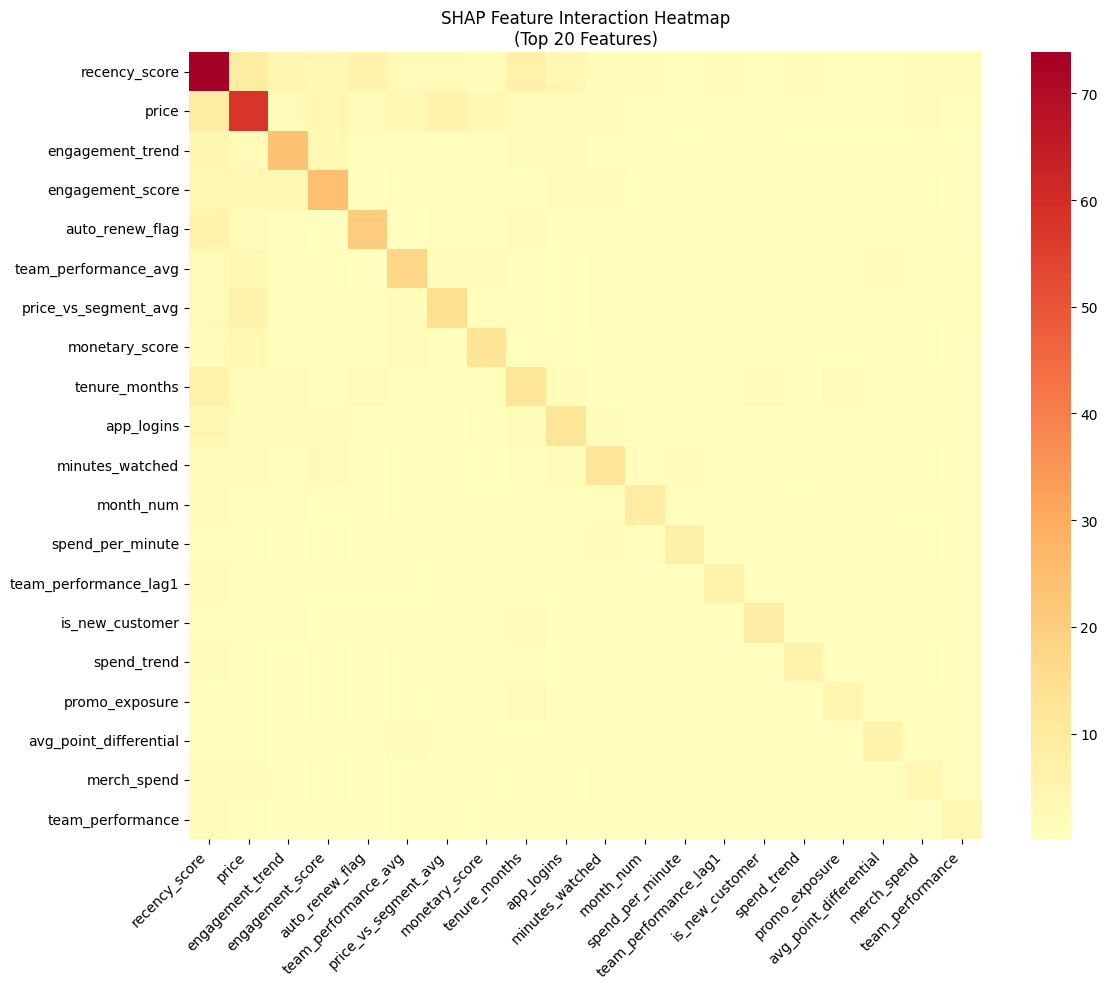


Top 15 Feature Interactions:
            feature_1             feature_2  interaction_strength
278             price         recency_score              9.014680
360     recency_score         tenure_months              7.005054
288             price  price_vs_segment_avg              6.271487
364     recency_score       auto_renew_flag              5.335756
233  engagement_trend         recency_score              4.161592
209  engagement_score         recency_score              4.085559
205  engagement_score                 price              3.876600
275             price        monetary_score              3.641956
44         app_logins         recency_score              3.585099
203  engagement_score      engagement_trend              3.472939
291             price  team_performance_avg              3.422008
229  engagement_trend                 price              2.951039
369     recency_score  team_performance_avg              2.692075
6     minutes_watched      engagement_score   

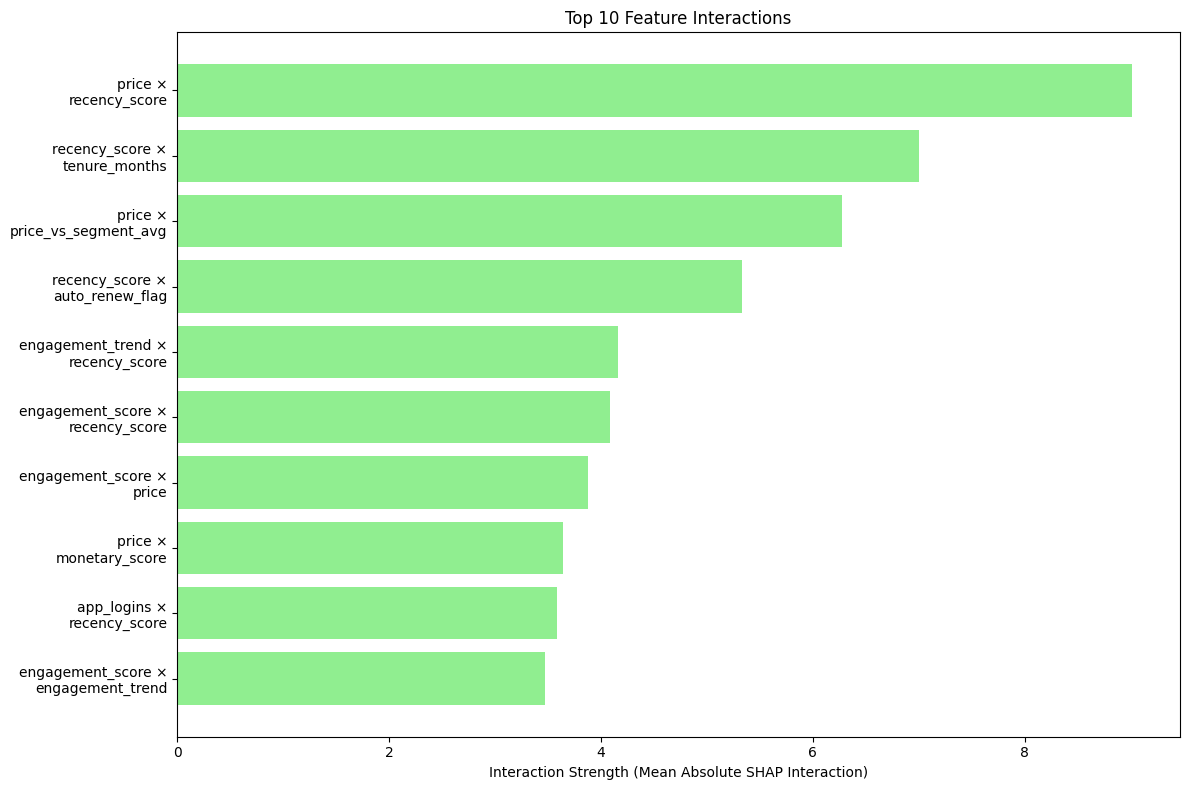

<Figure size 1000x600 with 0 Axes>

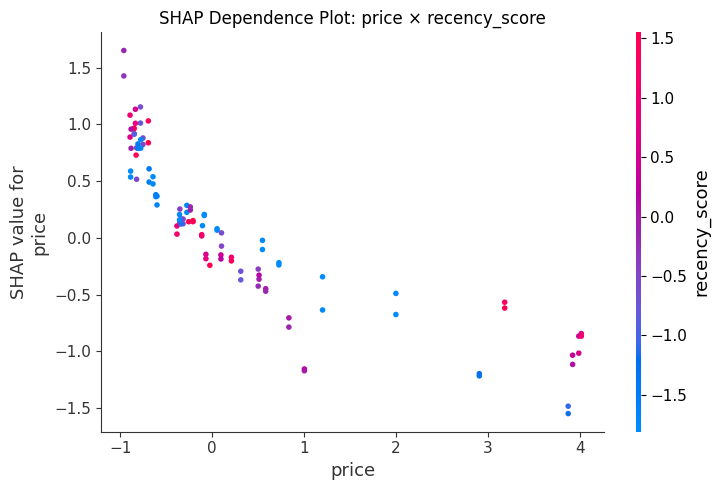

Feature interaction analysis completed successfully!
Analysis visualizations saved to: c:\Users\tifek\GitHub\basketball_fan_retention\data\processed\figures


In [9]:
# Calculate SHAP interaction values for a subset (computationally expensive)
# Use fewer samples for interaction analysis
n_interaction_samples = min(100, len(X_shap))
X_interaction = X_shap[:n_interaction_samples]

print(f"Calculating SHAP interaction values for {n_interaction_samples} samples...")
print("This may take a few minutes...")

try:
    # Calculate interaction values
    shap_interaction_values = explainer.shap_interaction_values(X_interaction)
    print(f"Interaction values shape: {shap_interaction_values.shape}")
    
    # 1. Feature Interaction Heatmap
    # Sum interaction effects across all samples
    interaction_matrix = np.abs(shap_interaction_values).sum(0)
    
    # Create interaction heatmap
    plt.figure(figsize=(12, 10))
    
    # Use top 20 features for readability
    top_features_idx = feature_importance_df.head(20).index
    top_feature_names = [feature_names[i] for i in top_features_idx]
    
    # Extract submatrix for top features
    interaction_submatrix = interaction_matrix[np.ix_(top_features_idx, top_features_idx)]
    
    # Create heatmap
    sns.heatmap(
        interaction_submatrix,
        xticklabels=top_feature_names,
        yticklabels=top_feature_names,
        annot=False,
        cmap='RdYlBu_r',
        center=0
    )
    plt.title('SHAP Feature Interaction Heatmap\n(Top 20 Features)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(figures_dir / 'shap_interaction_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Identify top feature pairs
    # Get upper triangle of interaction matrix (avoid duplicates)
    upper_triangle_mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=1)
    interaction_pairs = []
    
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            if upper_triangle_mask[i, j]:
                interaction_strength = interaction_matrix[i, j]
                interaction_pairs.append({
                    'feature_1': feature_names[i],
                    'feature_2': feature_names[j],
                    'interaction_strength': interaction_strength
                })
    
    # Convert to DataFrame and sort
    interaction_df = pd.DataFrame(interaction_pairs).sort_values('interaction_strength', ascending=False)
    
    print("\nTop 15 Feature Interactions:")
    print(interaction_df.head(15))
    
    # 3. Visualize top interactions
    top_interactions = interaction_df.head(10)
    
    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(top_interactions))
    
    plt.barh(y_pos, top_interactions['interaction_strength'], color='lightgreen')
    plt.yticks(y_pos, [f"{row['feature_1']} ×\n{row['feature_2']}" for _, row in top_interactions.iterrows()])
    plt.xlabel('Interaction Strength (Mean Absolute SHAP Interaction)')
    plt.title('Top 10 Feature Interactions')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(figures_dir / 'top_feature_interactions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Detailed interaction plot for top pair
    top_pair = interaction_df.iloc[0]
    feature_1_idx = feature_names.index(top_pair['feature_1'])
    feature_2_idx = feature_names.index(top_pair['feature_2'])
    
    # SHAP dependence plot with interaction
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feature_1_idx,
        shap_values[:n_interaction_samples],
        X_interaction,
        feature_names=feature_names,
        interaction_index=feature_2_idx,
        show=False
    )
    plt.title(f'SHAP Dependence Plot: {top_pair["feature_1"]} × {top_pair["feature_2"]}')
    plt.tight_layout()
    plt.savefig(figures_dir / 'shap_dependence_top_interaction.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Feature interaction analysis completed successfully!")
    
except Exception as e:
    print(f"Note: Full interaction analysis requires significant computation time.")
    print(f"Error: {e}")
    print("Showing alternative analysis using feature correlations...")
    
    # Alternative: Show correlation-based feature interactions
    correlation_matrix = np.corrcoef(X_shap.T)
    
    plt.figure(figsize=(12, 10))
    top_features_idx = feature_importance_df.head(20).index
    top_feature_names = [feature_names[i] for i in top_features_idx]
    correlation_submatrix = correlation_matrix[np.ix_(top_features_idx, top_features_idx)]
    
    sns.heatmap(
        correlation_submatrix,
        xticklabels=top_feature_names,
        yticklabels=top_feature_names,
        annot=True,
        cmap='RdYlBu_r',
        center=0,
        fmt='.2f'
    )
    plt.title('Feature Correlation Matrix\n(Top 20 Features by SHAP Importance)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(figures_dir / 'feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

print(f"Analysis visualizations saved to: {figures_dir}")

## Summary

This notebook will provide comprehensive model interpretability analysis using SHAP, helping understand:
- Which features drive churn predictions
- How features interact to influence outcomes
- Individual customer risk factors
- Actionable insights for retention strategies